## Background & Objectives — Counter‑factual Perturbations in LUCA

### 1. Terminal‑state simulation (tumour)

**Hypothesis:** Forced activation of stress/DNA-damage/apoptosis programs, or suppression of E2F/G2M programs, displaces tumour cells away from their native transcriptomic state.

**Goal:** Quantify this displacement **for every (cell-type × tumour-stage × mutation-combination)** and rank pathways or pathway cocktails that cause the strongest, consistent shifts.

### 2. Ground‑truth evaluation (CD8 T cells)

**Hypothesis:** An exhaustion‑signature knock‑up applied to effector‑memory CD8 cells will move them along the low‑dimensional axis connecting baseline and bona‑fide exhausted cells.

**Goal:** Measure **signed axial alignment** and clustering quality; confirm that perturbed cells sit closer to ground‑truth exhausted cells.

---

## Pathway Assumptions and Directionality

**Key assumptions:**

* **Hallmark gene sets** (MSigDB) provide sets of genes associated with particular biological processes.
* **Directionality assumption:**

  * "Up" pathways indicate activation of gene sets positively correlated with the hallmark phenotype (genes are expected to increase).
  * "Down" pathways indicate suppression of hallmark-associated genes (genes are expected to decrease).
* This directionality (up/down) is defined explicitly by the experimental hypothesis and context, not inherently annotated by the hallmark database itself, which typically only defines gene membership, not directionality.

**Practical Implementation:**

* "Up" perturbations increase gene expression to near the observed maximum or increase by MAD multiples.
* "Down" perturbations decrease gene expression to near observed minimum or reduce by MAD multiples.

---

## Pathways and Expected Directions

| Pathway               | Hallmark Geneset                           | Expected Direction (Tumour) | Relevance to Context                                  |
| --------------------- | ------------------------------------------ | --------------------------- | ----------------------------------------------------- |
| **P53**               | `HALLMARK_P53_PATHWAY`                     | ↑ (Activated)               | Cell cycle arrest, DNA repair, apoptosis              |
| **Apoptosis**         | `HALLMARK_APOPTOSIS`                       | ↑ (Activated)               | Programmed cell death reducing tumour viability       |
| **UPR**               | `HALLMARK_UNFOLDED_PROTEIN_RESPONSE`       | ↑ (Activated)               | Induces apoptosis under chronic stress                |
| **ROS**               | `HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY` | ↑ (Activated)               | Promotes apoptosis through oxidative stress           |
| **IFNγ**              | `HALLMARK_INTERFERON_GAMMA_RESPONSE`       | ↑ (Activated)               | Enhances anti-tumour immune recognition and clearance |
| **Cell Cycle Arrest** | `HALLMARK_CELL_CYCLE_ARREST`               | ↑ (Activated)               | Immediate inhibition of tumour cell proliferation     |
| **E2F**               | `HALLMARK_E2F_TARGETS`                     | ↓ (Suppressed)              | Blocks G1→S progression, growth inhibition            |
| **G2M**               | `HALLMARK_G2M_CHECKPOINT`                  | ↓ (Suppressed)              | Blocks cell division, reduces proliferation           |
| **MYC**               | `HALLMARK_MYC_TARGETS_V1`                  | ↓ (Suppressed)              | Suppresses proliferative and metabolic capacity       |
| **mTOR**              | `HALLMARK_MTORC1_SIGNALING`                | ↓ (Suppressed)              | Inhibits growth signaling, restricts proliferation    |

---

## Key Metric Definitions (Jupyter-friendly Formulas)

Let $C_b$, $C_t$ represent centroids of baseline and target states in embedding space, respectively, and $C_p$ represent the centroid of a perturbation.

* **Axial progress**:

$$
s = \frac{(C_p - C_b)\cdot(C_t - C_b)}{\|C_t - C_b\|}
$$

* **Signed axial cosine**:

$$
\cos\theta = \frac{(C_p - C_b)\cdot(C_t - C_b)}{\|(C_p - C_b)\| \cdot \|(C_t - C_b)\|}
$$

* **Cluster quality metrics**: silhouette, Davies–Bouldin indices on the combined baseline and simulation sets.


### A1 · Configuration (cell #1)

In [1]:
CFG_A = dict(
    # data
    raw_h5ad = "/home/helical_team/issac/data/raw_data_collection/36368318_LuCA_lung_cancer_atlas/80b57568-2621-4911-b4b1-4f2cf5087962.h5ad",
    outdir   = "outputs/luca_A_terminal",
    # experiment
    disease_filter = "lung adenocarcinoma",
    tumour_celltypes = [
        "Tumor cells LUAD", 
        #"Tumor cells LUAD EMT", 
        #"Tumor cells LUAD mitotic",
        #"Tumor cells LUAD NE", 
        #"Tumor cells LUAD MSLN", 
        #"Tumor cells NSCLC mixed",
        #"Tumor cells LUSC", 
        #"Tumor cells LUSC mitotic",
    ],
    stage_col   = "tumor_stage",
    mut_cols    = [c for c in (
        "TP53_mutation","ALK_mutation","BRAF_mutation","ERBB2_mutation",
        "KRAS_mutation","ROS_mutation","EGFR_mutation")],
    # sampling
    cells_per_split = 200,
    rng_seed        = 1,
    # pathway dictionary  ← *extend or edit freely*
    pathways = {
        # name            (gene‑set,        tokens, direction)
        "P53"        : ("HALLMARK_P53_PATHWAY",                   ("max",), "up"),
        #"Cell Cycle Arrest": ("HALLMARK_CELL_CYCLE_ARREST", ("max",4,6), "up"),
        "Apoptosis"  : ("HALLMARK_APOPTOSIS",                     ("max",), "up"),
        #"UPR"        : ("HALLMARK_UNFOLDED_PROTEIN_RESPONSE",     ("max",4,6), "up"),
        #"ROS"        : ("HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY",("max",4,6),"up"),
        #"IFNγ"       : ("HALLMARK_INTERFERON_GAMMA_RESPONSE",     ("max",), "up"),
        "E2F"        : ("HALLMARK_E2F_TARGETS",                   ("min",), "down"),
        "G2M"        : ("HALLMARK_G2M_CHECKPOINT",                ("min",), "down"),
        #"MYC"        : ("HALLMARK_MYC_TARGETS_V1",                ("min",), "down"),
        #"mTOR"       : ("HALLMARK_MTORC1_SIGNALING",              ("min",4,6), "down"),
    },
    # embedding
    scgpt_cfg = "./config/inference_scgpt.yaml",
)


### A2 · Helper library (cell #2)

In [2]:
import numpy as np, pandas as pd, scanpy as sc, scipy.sparse as sp, random, requests, yaml
from pathlib import Path
from itertools import chain, combinations
from sklearn.metrics.pairwise import cosine_distances
from tqdm.auto import tqdm
random.seed(CFG_A["rng_seed"]); np.random.seed(CFG_A["rng_seed"])

OUT_A = Path(CFG_A["outdir"]); OUT_A.mkdir(parents=True, exist_ok=True)

# ───── 1. download Hallmark once ───────────────────────────────────── #
from urllib.parse import quote
import requests

_cache = {}

def fetch_all_hallmarks():
    if "HALLMARK_ALL" in _cache:
        return _cache["HALLMARK_ALL"]
    url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/7.5.1/h.all.v7.5.1.symbols.gmt"
    response = requests.get(url, timeout=60)
    response.raise_for_status()
    hallmarks = {}
    for line in response.text.strip().split('\n'):
        parts = line.split('\t')
        pathway_name = parts[0]
        genes = parts[2:]
        hallmarks[pathway_name] = genes
    _cache["HALLMARK_ALL"] = hallmarks
    return hallmarks

# Call this once at the beginning
all_hallmarks = fetch_all_hallmarks()

def hallmark(gs:str):
    hallmarks = fetch_all_hallmarks()
    if gs not in hallmarks:
        raise ValueError(f"{gs} not found in the hallmark collection.")
    return hallmarks[gs]

# ───── 2. MAD‑based knock functions ───────────────────────────────── #
def _knock(token,row,mode):
    if token=="max":  return lambda v,mx=row["max"]: np.full_like(v,mx)
    if token=="min":  return lambda v,mn=row["min"]: np.full_like(v,mn)
    k=float(token); Δ=k*row["mad"]
    if mode=="up"  : return lambda v,d=Δ,m=row["med"]: np.maximum(v+d, m+row["mad"])
    if mode=="down": return lambda v,d=Δ,m=row["med"],mn=row["min"]: np.maximum(np.minimum(v-d,m-row["mad"]),mn)

def gene_stats(ad):
    X=ad.X.toarray() if sp.issparse(ad.X) else ad.X
    med=np.median(X,0); mad=np.median(abs(X-med),0)*1.4826
    return dict(med=med,mad=mad,min=X.min(0),max=X.max(0))

# ───── 3. mutation signature label ────────────────────────────────── #
def mut_signature(row, cols):
    muts=[c.replace("_mutation","") for c in cols if row[c]]
    return "+".join(sorted(muts)) or "WT"


### A3 · Load & slice LUCA tumour data (cell #3)

In [3]:
import numpy as np
import scipy.sparse as sp

# Load AnnData in backed mode
adata_raw = sc.read_h5ad(CFG_A["raw_h5ad"], backed="r")

# Define composite mask including all filters
mask = (
    (adata_raw.obs["disease"] == CFG_A["disease_filter"]) &
    (adata_raw.obs["cell_type_tumor"].isin(CFG_A["tumour_celltypes"])) &
    (adata_raw.obs["origin"].isin(["tumor_primary"])) &
    (adata_raw.obs["tumor_stage"].isin(["early"]))
)

# Apply mask and load into memory
a_tum = adata_raw[mask].to_memory()
a_tum.var["genes"] = a_tum.var["feature_name"].str.split("_").str[0]
a_tum.var = a_tum.var.set_index('genes', drop=False)
a_tum.var_names_make_unique()

# convert to raw:
# Step 1: Undo log1p transform
X_log = a_tum.X

if sp.issparse(X_log):
    X_log = X_log.tocoo()
    X_cptt_data = np.expm1(X_log.data)
    X_cptt = sp.csr_matrix((X_cptt_data, (X_log.row, X_log.col)), shape=X_log.shape)
else:
    X_cptt = np.expm1(X_log)

# Step 2: Get library size scale factors
cell_sums = a_tum.obs["total_counts"].values  # real per-cell library size
scale_factors = cell_sums / 1e4  # counts per 10k

# Step 3: Rescale
if sp.issparse(X_cptt):
    from scipy.sparse import diags
    X_raw = diags(scale_factors) @ X_cptt
else:
    X_raw = X_cptt * scale_factors[:, None]
a_tum.X = X_raw.astype(int)

In [4]:
a_tum.obs.columns

Index(['sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin',
       'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status',
       'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito',
       'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage',
       'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation',
       'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform',
       'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse',
       'suspension_type', 'assay_ontology_term_id',
       'cell_type_ontology_term_id', 'development_stage_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'tissue_type', 'EGFR_mutation', 'cell_type',
       'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'obser

### A4 · Generate baseline + all perturbations (cell #4)

In [5]:
def generate_theme_combos(pathways, theme):
    # Generate combinations only for a specific theme
    singles = [(theme,)]
    others = [p for p in pathways if p != theme]
    combos = [tuple(sorted([theme] + list(c))) for r in range(1, len(others)+1)
              for c in combinations(others, r)]
    return singles + combos

def perturbation_label(combo, pathway_dirs):
    return "_".join(f"{p}{'+' if pathway_dirs[p]=='up' else '-'}" for p in combo)

def simulate_tumour(adata):
    adata.obs["mut_sig"] = adata.obs.apply(mut_signature, axis=1, cols=CFG_A["mut_cols"])
    strata_cols = ["cell_type_tumor", "mut_sig", CFG_A["stage_col"]]
    adata.obs["strata_id"] = adata.obs[strata_cols].astype(str).agg("|".join, axis=1)

    gstats = gene_stats(adata)
    idx = {g: i for i, g in enumerate(adata.var_names)}

    clones = []
    rng = np.random.default_rng(CFG_A["rng_seed"])

    pathways = CFG_A["pathways"]
    pathway_dirs = {k: v[2] for k, v in pathways.items()}

    all_combos = []
    for r in range(1, len(pathways) + 1):
        all_combos += list(combinations(pathways, r))

    for sid, rows in tqdm(adata.obs.groupby("strata_id").groups.items(), desc="strata"):
        base_idx = rng.choice(rows, min(CFG_A["cells_per_split"], len(rows)), replace=False)
        base = adata[base_idx].copy()
        base.obs["sim_type"] = "baseline"
        clones.append(base)

        for combo in all_combos:
            tag = perturbation_label(combo, pathway_dirs)
            pert = base.copy()

            # Dense float array for perturbation
            M = pert.X.toarray().astype(np.float32, copy=False) if sp.issparse(pert.X) else pert.X.astype(np.float32, copy=False)

            for p in combo:
                genes, toks, mode = pathways[p]
                gene_list = hallmark(genes)
                for g in gene_list:
                    if g not in idx: continue
                    col = idx[g]
                    for tk in toks:
                        fn = _knock(tk, {k: gstats[k][col] for k in gstats}, mode)
                        M[:, col] = fn(M[:, col])

            M = np.round(np.clip(M, 0, None)).astype(np.int32)
            pert.X = sp.csr_matrix(M)
            pert.obs["sim_type"] = f"pert:{tag}"

            clones.append(pert)

    return sc.concat(clones, index_unique="_")



a_tum_sim=simulate_tumour(a_tum)
a_tum_sim.X = a_tum_sim.X.astype(int)
a_tum_sim.write(OUT_A/"tumour_sim.h5ad")
print(a_tum_sim.obs["sim_type"].value_counts().head())

strata:   0%|          | 0/1 [00:00<?, ?it/s]

sim_type
baseline                     200
pert:Apoptosis+              200
pert:Apoptosis+_E2F-         200
pert:Apoptosis+_E2F-_G2M-    200
pert:Apoptosis+_G2M-         200
Name: count, dtype: int64


### A5 · Embedding with scGPT (cell #5)

In [6]:
from bioagents.inference.run import run_inference
from bioagents.inference.inference_config import InferenceConfig
import yaml
import numpy as np

def embed_multiple_models(path_h5ad, cfg_yaml, embed_keys=["scgpt", "geneformer"]):
    # Load configs from YAML
    configs = yaml.safe_load(open(cfg_yaml))
    
    embeddings = {}
    for key in embed_keys:
        cfg_dict = configs[key]
        cfg_dict["data"] = str(path_h5ad)
        cfg = InferenceConfig(**cfg_dict)
        
        # run_inference directly returns embeddings as ndarray
        embedding_array = run_inference(cfg)
        embeddings[key] = embedding_array.copy()
    
    return embeddings

# Run embeddings and save in AnnData directly
embeddings = embed_multiple_models(OUT_A/"tumour_sim.h5ad", "./config/inference.yaml",
                                   embed_keys=["scgpt", "gf-12L-95M-i4096"])

for key, emb in embeddings.items():
    a_tum_sim.obsm[f"X_{key}"] = emb

a_tum_sim.write(OUT_A/"tumour_sim_emb.h5ad")



INFO:datasets:PyTorch version 2.6.0 available.
INFO:datasets:JAX version 0.5.2 available.
  warnings.warn("flash_attn is not installed")

INFO:bioagents.data_etl.etl:Assuming AnnData. Reading from outputs/luca_A_terminal/tumour_sim.h5ad
INFO:bioagents.data_etl.etl:Reading data from local URI: outputs/luca_A_terminal/tumour_sim.h5ad
INFO:bioagents.data_etl.etl:Successfully retrieved data from outputs/luca_A_terminal/tumour_sim.h5ad
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:'scGPT' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:bioagents.fine_tuning.scgpt.scgpt_fine_tuning:scGPT fine-tuning model initialized
INFO:helical.models.scgpt.model:Processing data for scGPT.
INFO:helical.models.scgpt.model:Filtering out 259 genes to a total of 17538 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.


  0%|          | 0/134 [00:00<?, ?it/s]

INFO:bioagents.fine_tuning.fine_tuning_agent:Saved results to ../outputs/inference_output/scGPTFineTuning_embeddings.npy
INFO:bioagents.data_etl.etl:Assuming AnnData. Reading from outputs/luca_A_terminal/tumour_sim.h5ad
INFO:bioagents.data_etl.etl:Reading data from local URI: outputs/luca_A_terminal/tumour_sim.h5ad
INFO:bioagents.data_etl.etl:Successfully retrieved data from outputs/luca_A_terminal/tumour_sim.h5ad
INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-95M-i4096-CLcancer' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:bioagents.fine_tuning.geneformer.geneformer_fine_tuning:Geneformer fine-tuning model initialized
INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/issac/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.


  0%|          | 0/134 [00:00<?, ?it/s]

INFO:bioagents.fine_tuning.fine_tuning_agent:Saved results to ../outputs/inference_output/GeneformerFineTuning_embeddings.npy


### A6 · Distance & quality metrics (cell #6)

In [7]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

def displacement_multi_embedding(adata, embed_keys):
    labs = adata.obs["sim_type"].values
    strata = adata.obs["strata_id"].values
    results = []

    for embed_key in embed_keys:
        X = adata.obsm[embed_key]

        for sid in np.unique(strata):
            maskS = strata == sid
            Cb = X[(maskS) & (labs == "baseline")].mean(0, keepdims=True)

            for p in np.unique(labs[maskS]):
                if p == "baseline":
                    continue
                Cp = X[(maskS) & (labs == p)].mean(0, keepdims=True)

                cos_dist = float(cosine_distances(Cp, Cb))
                results.append({
                    "embedding": embed_key,
                    "strata": sid,
                    "pert": p,
                    "cosine_distance": cos_dist,
                    "n_cells": maskS.sum()
                })

    return pd.DataFrame(results)

# Example usage:
embed_cols = ["X_scgpt", "X_gf-12L-95M-i4096"]
df_disp = displacement_multi_embedding(a_tum_sim, embed_cols)

# Inspect top perturbations for each embedding
for emb in embed_cols:
    print(f"Top perturbations for embedding {emb}:")
    display(df_disp[df_disp.embedding == emb]
            .groupby("pert")["cosine_distance"]
            .mean()
            .sort_values(ascending=False)
            .head())



Top perturbations for embedding X_scgpt:


pert
pert:P53+_Apoptosis+_E2F-_G2M-    0.047188
pert:P53+_Apoptosis+_E2F-         0.046134
pert:P53+_Apoptosis+_G2M-         0.046048
pert:P53+_Apoptosis+              0.041639
pert:P53+_E2F-_G2M-               0.031548
Name: cosine_distance, dtype: float64

Top perturbations for embedding X_gf-12L-95M-i4096:


pert
pert:E2F-_G2M-         0.090274
pert:E2F-              0.089035
pert:G2M-              0.088994
pert:P53+_E2F-_G2M-    0.066570
pert:P53+_E2F-         0.065985
Name: cosine_distance, dtype: float64


### Analysis based on embedding: X_scgpt ###



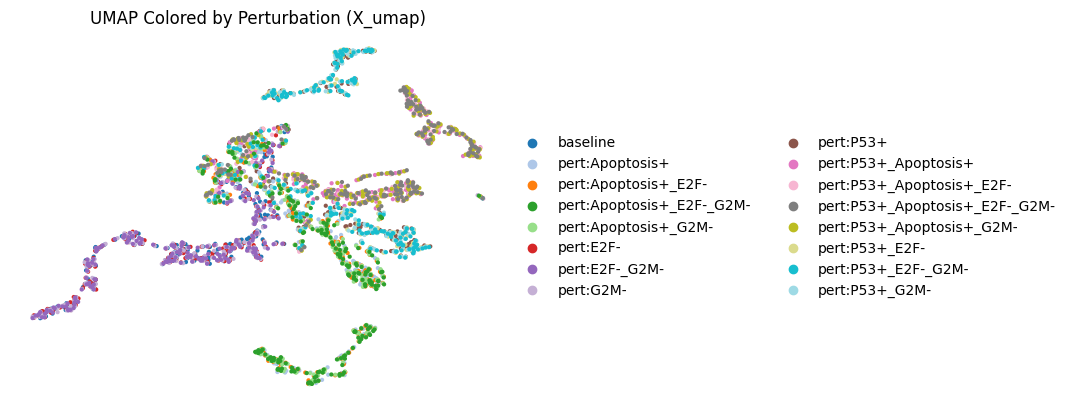

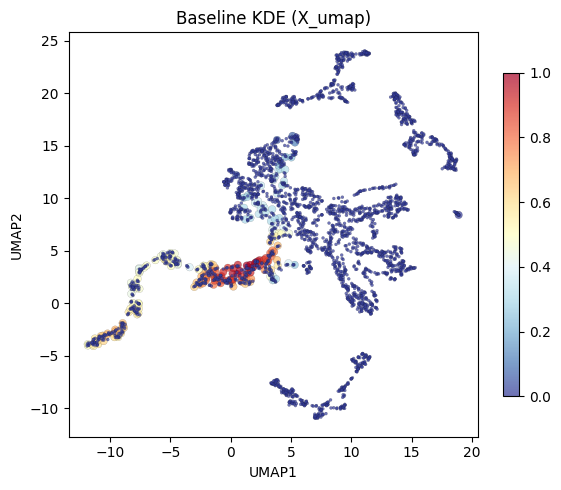

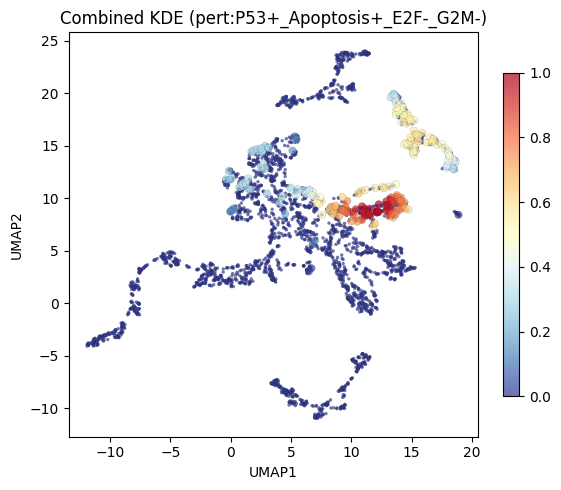

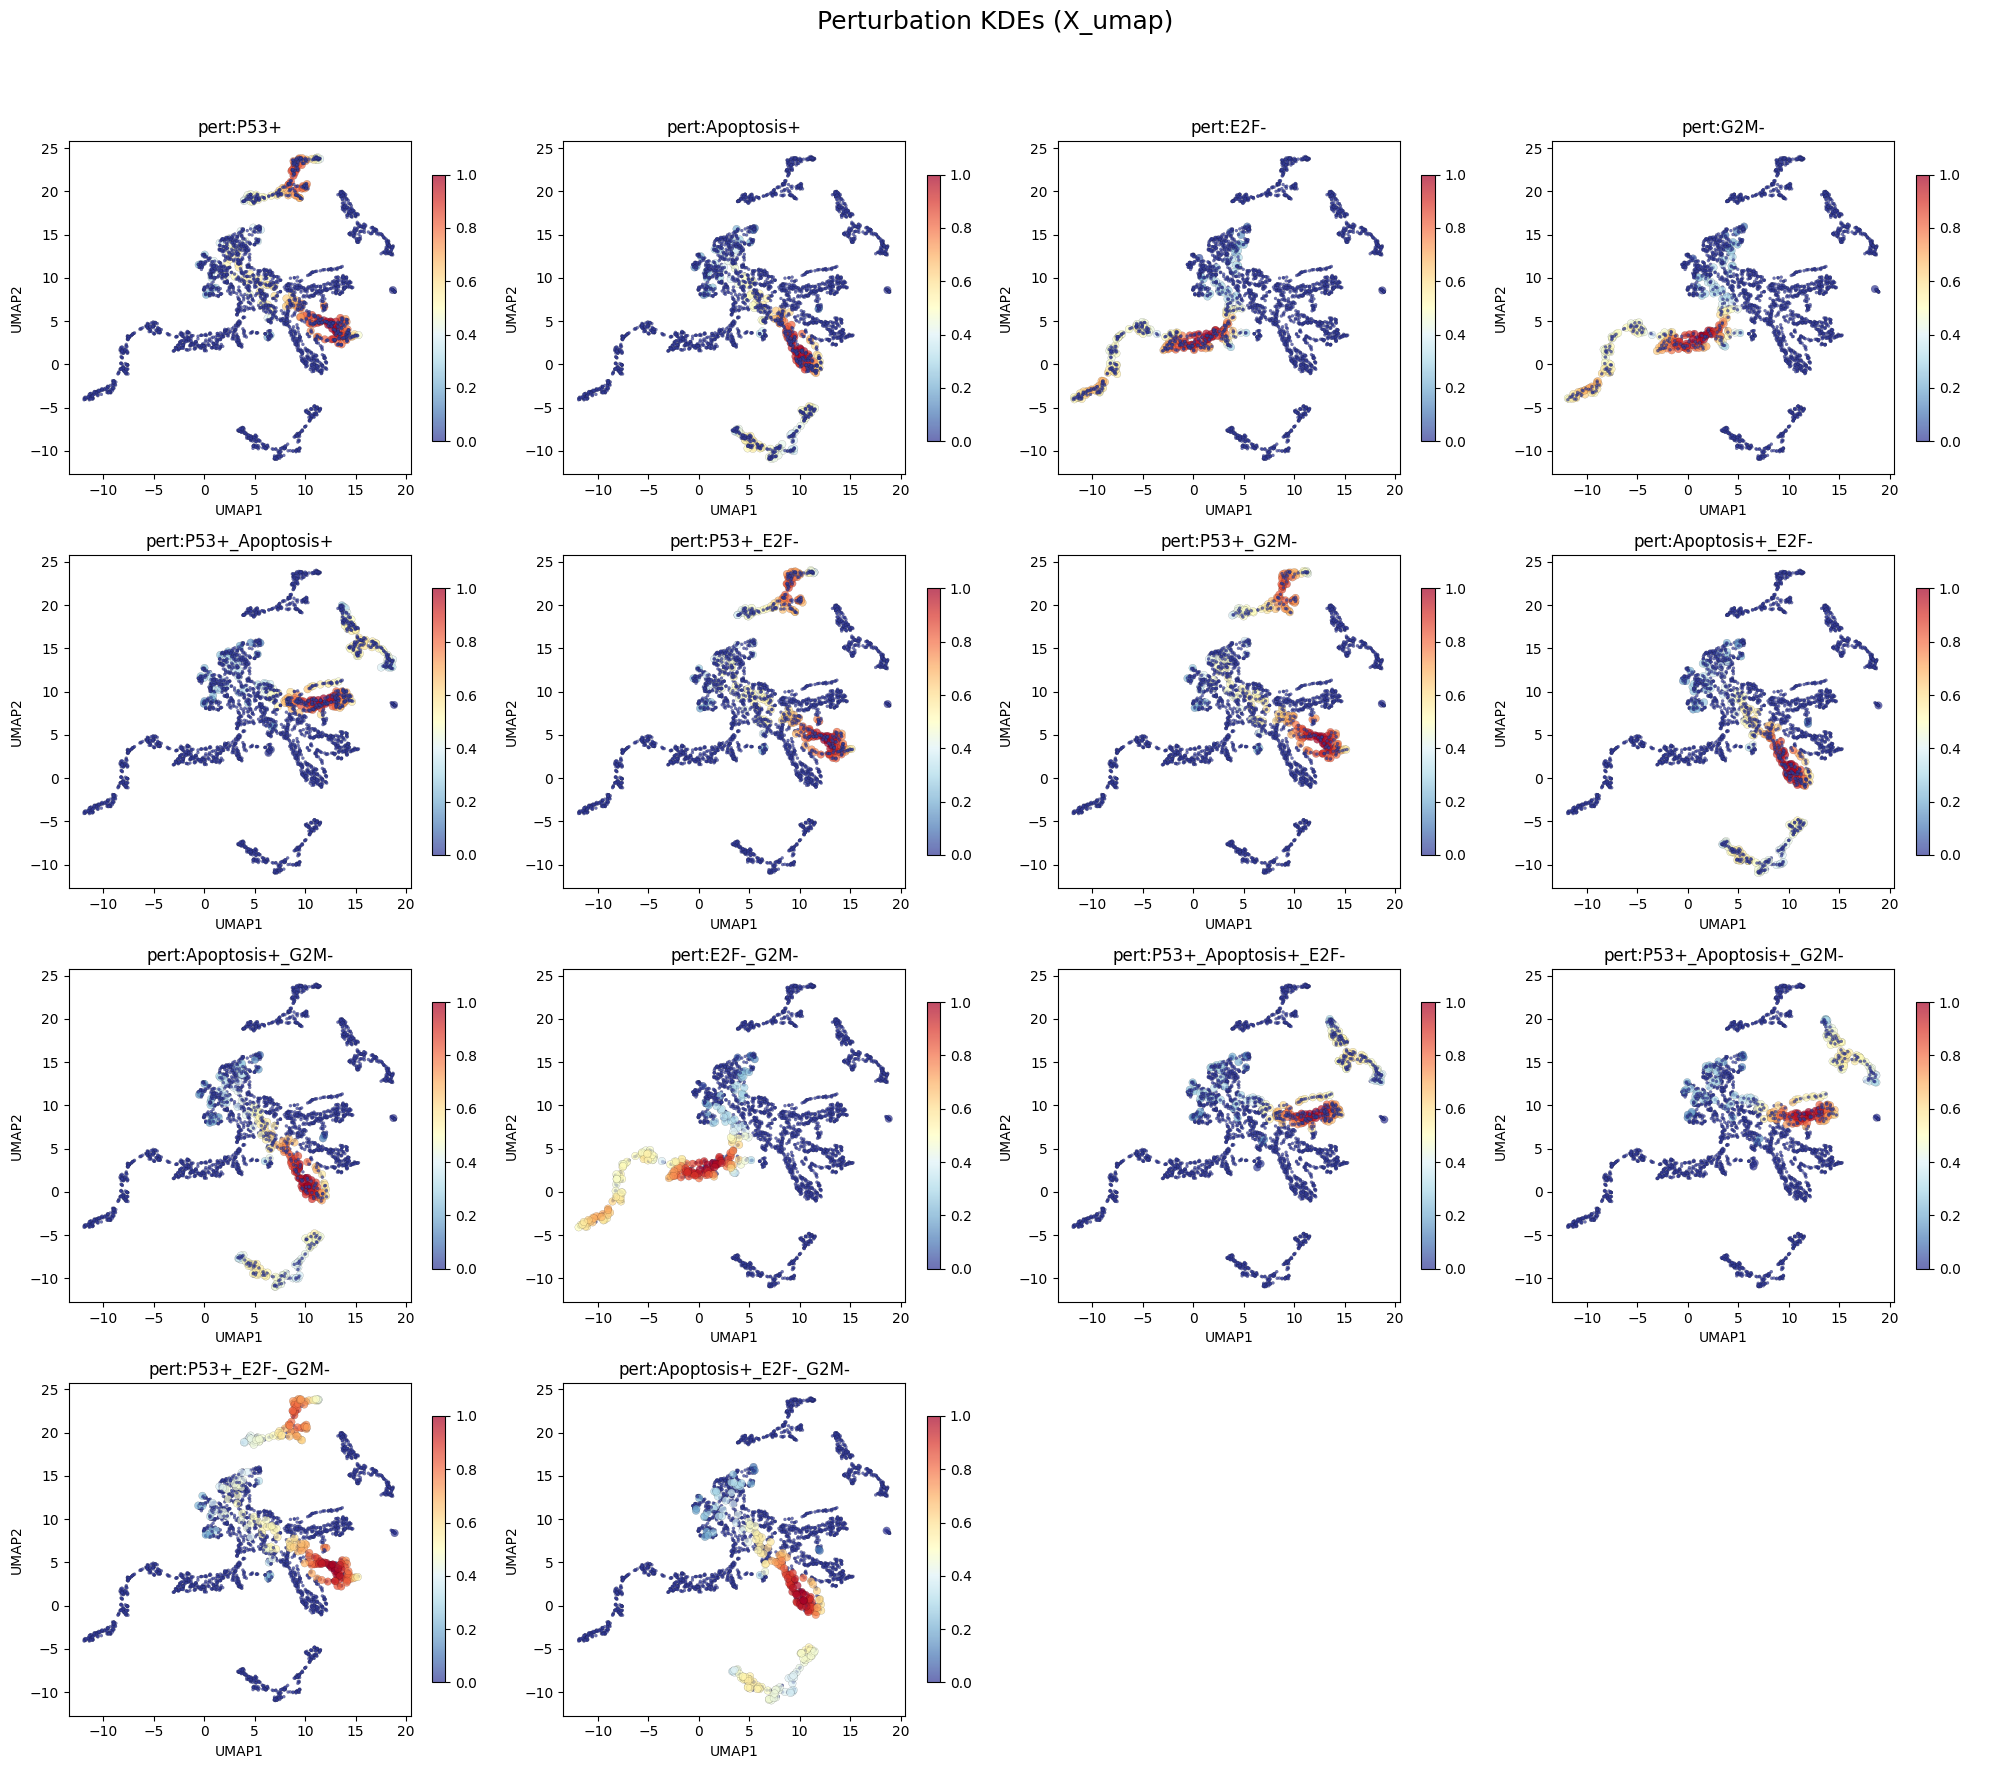

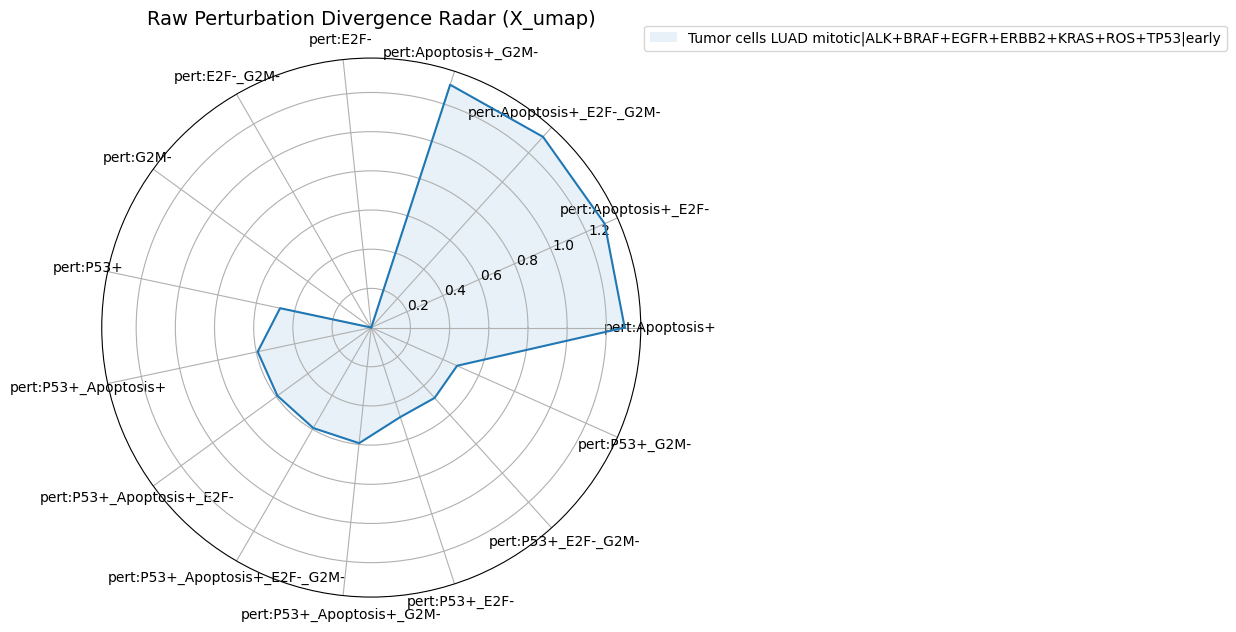

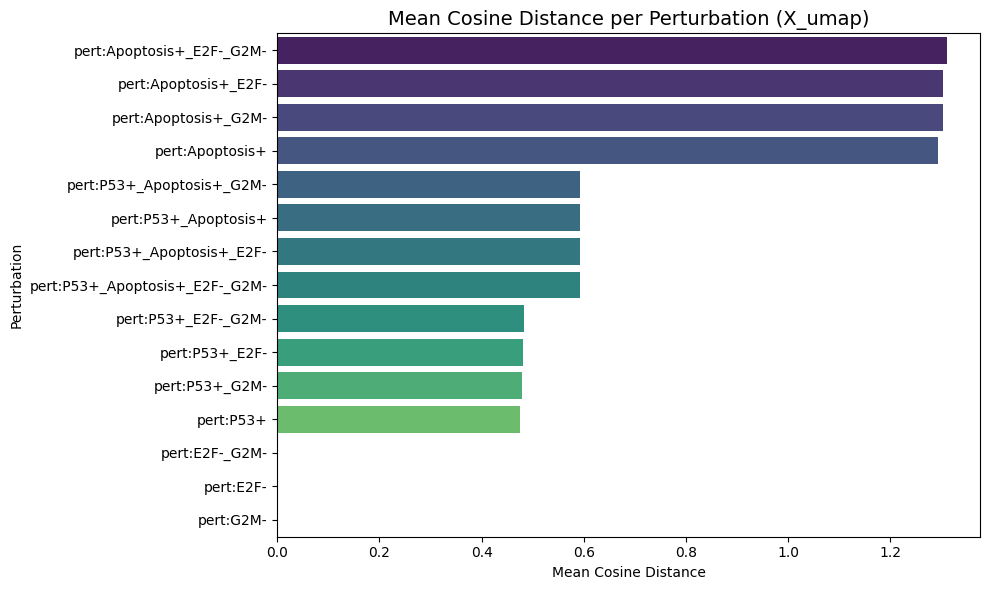


Top perturbations for embedding X_umap:


pert
pert:Apoptosis+_E2F-_G2M-    1.310180
pert:Apoptosis+_E2F-         1.304182
pert:Apoptosis+_G2M-         1.303381
pert:Apoptosis+              1.293679
pert:P53+_Apoptosis+_G2M-    0.593507
Name: cosine_distance, dtype: float64


### Analysis based on embedding: X_gf-12L-95M-i4096 ###



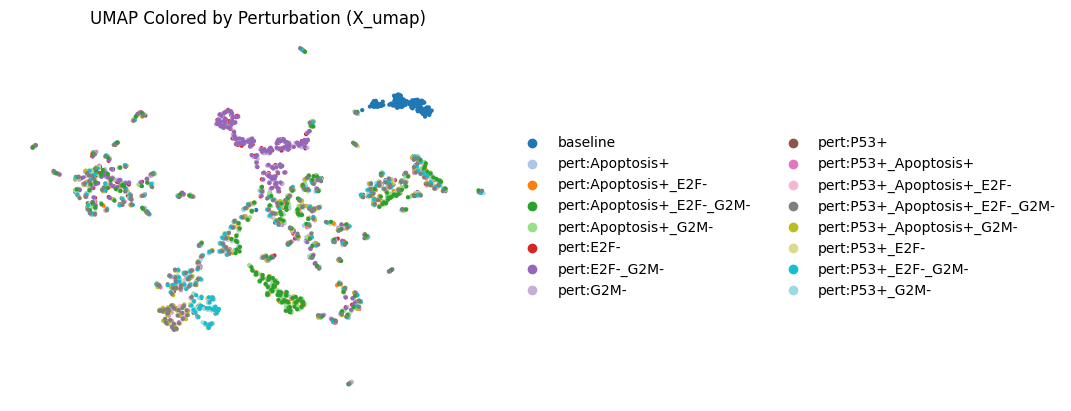

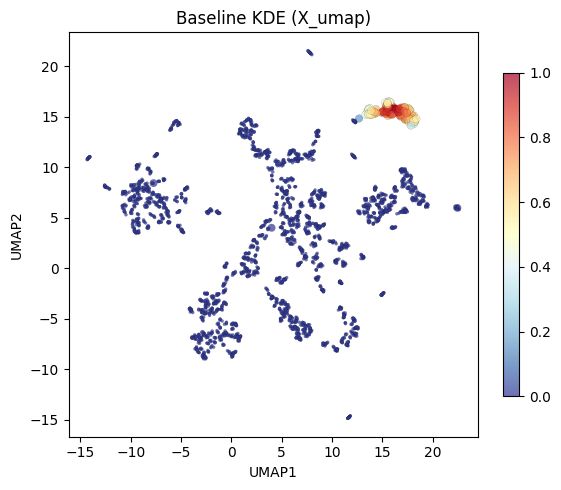

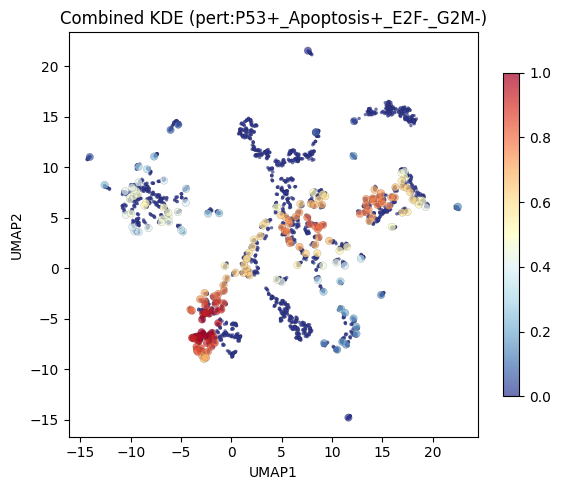

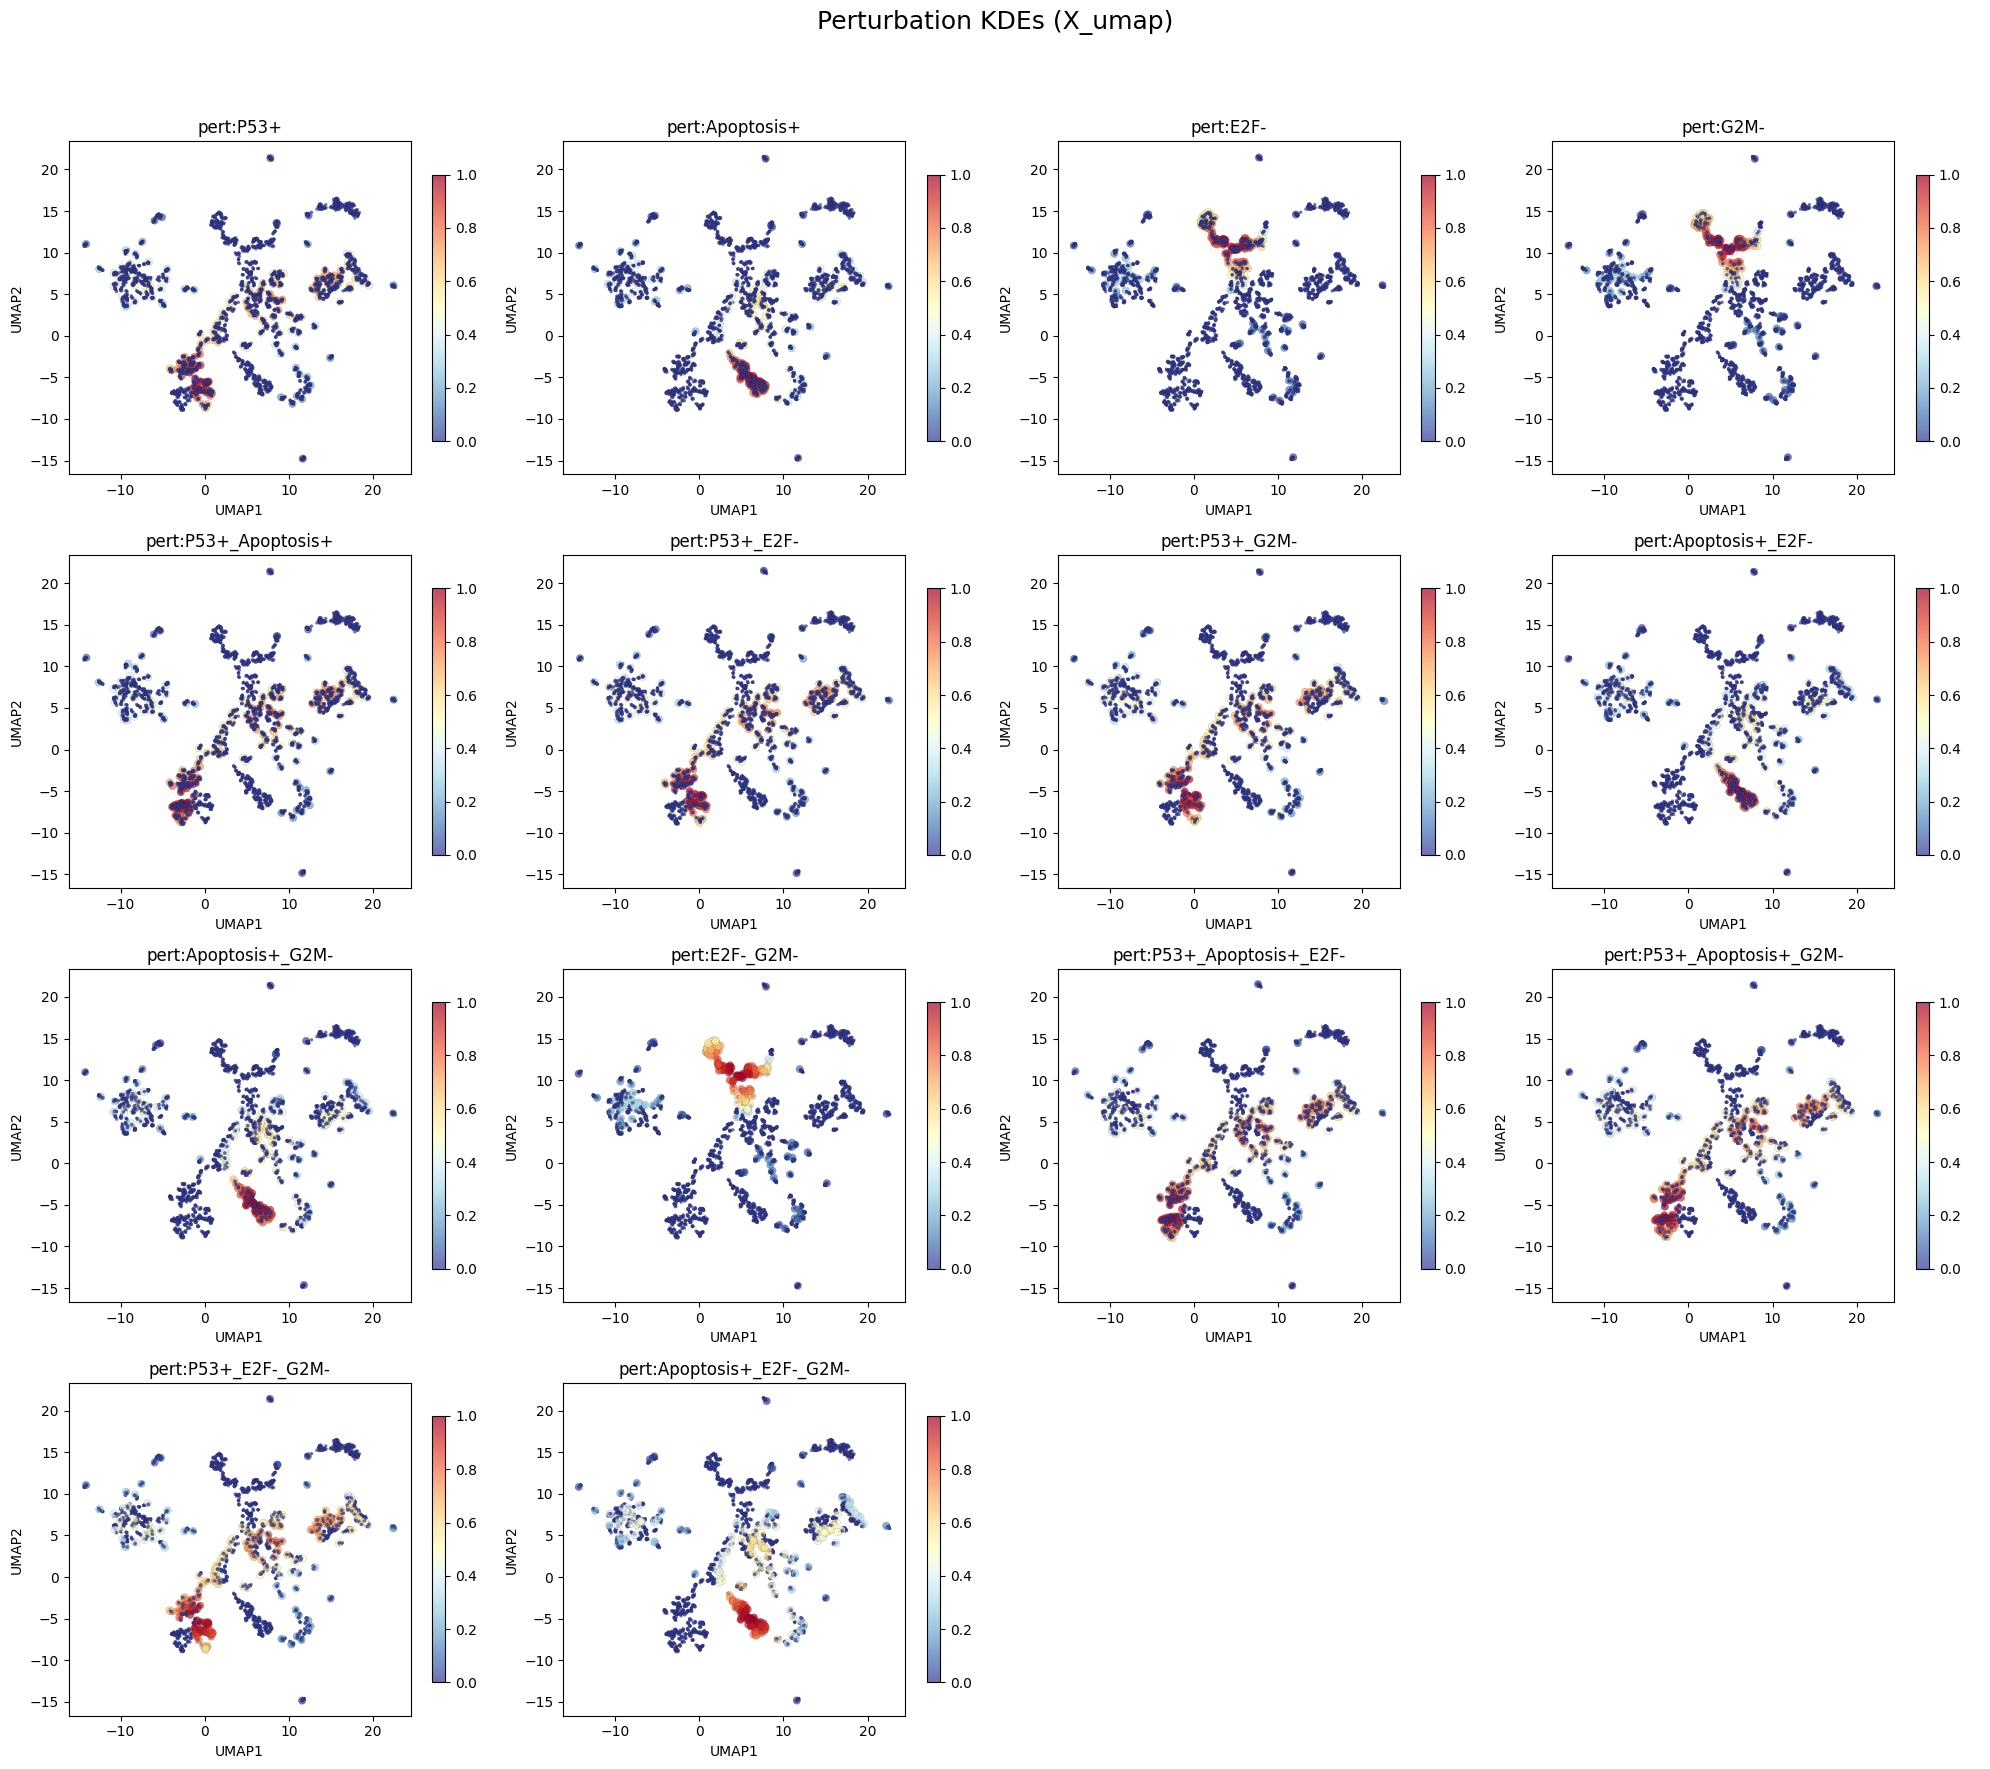

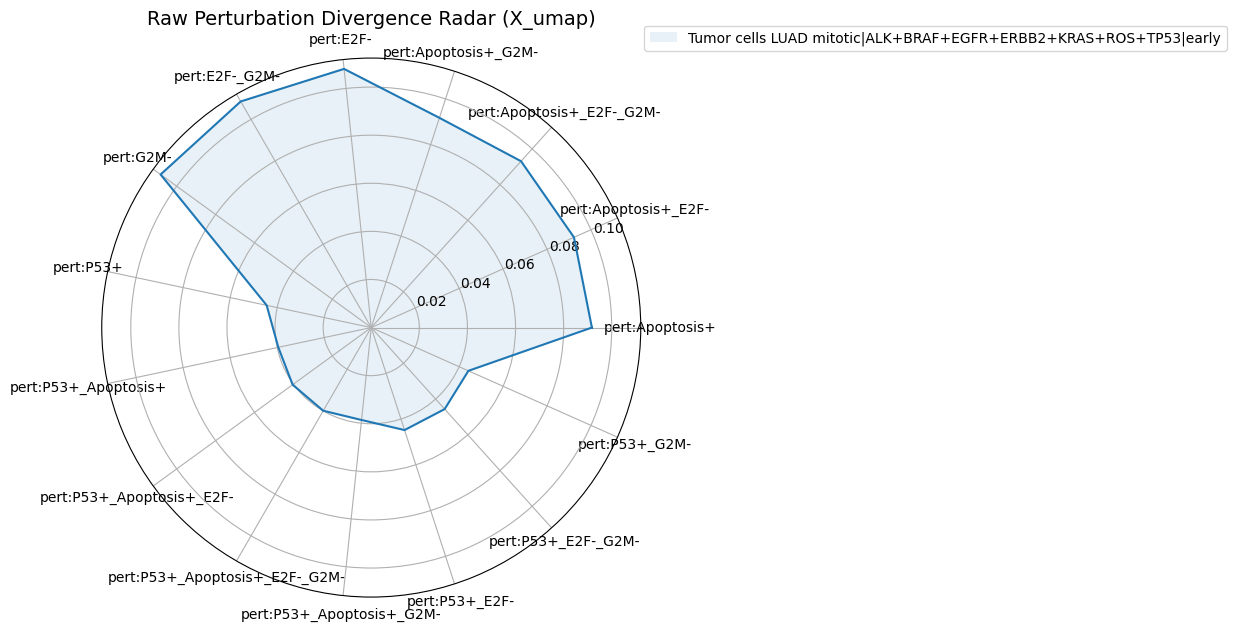

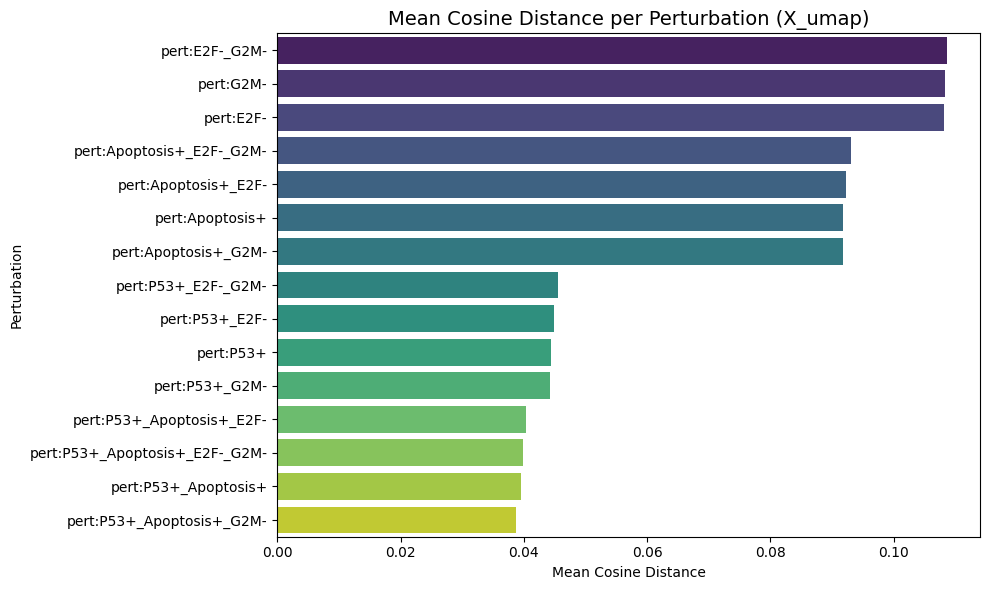


Top perturbations for embedding X_umap:


pert
pert:E2F-_G2M-               0.108580
pert:G2M-                    0.108291
pert:E2F-                    0.108164
pert:Apoptosis+_E2F-_G2M-    0.093092
pert:Apoptosis+_E2F-         0.092276
Name: cosine_distance, dtype: float64

In [18]:
embed_cols = ["X_scgpt", "X_gf-12L-95M-i4096"]

for emb in embed_cols:
    print(f"\n### Analysis based on embedding: {emb} ###\n")

    # Step 1: Compute UMAP based on current embedding
    adata_emb = compute_umap_and_density(a_tum_sim, emb)

    # Persist UMAP coordinates back to main object clearly
    a_tum_sim.obsm["X_umap"] = adata_emb.obsm["X_umap"]

    # Step 2: Choose embedding for displacement calculation explicitly here:
    # For metrics calculated in UMAP space use "X_umap",
    # or to use the original embedding, set to `emb`
    metric_embedding = "X_umap"  # or emb if you prefer original embeddings

    # Step 3: Compute displacement
    df_disp = displacement_multi_embedding(a_tum_sim, [metric_embedding])

    # Step 4: Visualizations based on the chosen metric_embedding
    visualize_umap(adata_emb, embed_label=metric_embedding)
    plot_kde_by_perturbation(adata_emb, embed_label=metric_embedding)

    radar_plot(df_disp, embed_label=metric_embedding, scaled=False)
    bar_plot(df_disp, embed_label=metric_embedding)

    # Step 5: Display top perturbations clearly
    print(f"\nTop perturbations for embedding {metric_embedding}:")
    top_perturbations = (df_disp.groupby("pert")["cosine_distance"]
                         .mean()
                         .sort_values(ascending=False)
                         .head())
    display(top_perturbations)



# Eval: Ground truth exhaustion experiment

In [11]:
CFG_B = dict(
    raw_h5ad = CFG_A["raw_h5ad"],          # same LUCA atlas
    outdir   = "outputs/luca_B_cd8",
    baseline = "T cell CD8 effector memory",
    terminal = "T cell CD8 terminally exhausted",
    cells_sample = 300,
    pathway = dict(                        # can extend to more
        Exh_IFNG = dict(
            hallmark = "HALLMARK_INTERFERON_GAMMA_RESPONSE",
            tokens   = ("max", 4, 6),
            mode     = "up"
        ),
        Exh_TNFA = dict(
            hallmark = "HALLMARK_TNFA_SIGNALING_VIA_NFKB",
            tokens   = ("max", 4, 6),
            mode     = "up"
        ),
    ),
    rng_seed = 99,
    scgpt_cfg = CFG_A["scgpt_cfg"],        # reuse the same YAML
)
OUT_B = Path(CFG_B["outdir"]); OUT_B.mkdir(parents=True, exist_ok=True)
random.seed(CFG_B["rng_seed"]); np.random.seed(CFG_B["rng_seed"])


In [12]:
mask = adata_raw.obs["cell_type_tumor"].isin([CFG_B["baseline"],
                                              CFG_B["terminal"]])
a_cd8 = adata_raw[mask].to_memory()

# baseline sample
base = a_cd8[a_cd8.obs["cell_type_tumor"] == CFG_B["baseline"]]
idx  = np.random.choice(base.obs_names,
                        min(CFG_B["cells_sample"], base.n_obs),
                        replace=False)
base = base[idx].copy(); base.obs["sim_type"] = "baseline"

# terminal (ground truth) for scoring only
gt   = a_cd8[a_cd8.obs["cell_type_tumor"] == CFG_B["terminal"]].copy()


In [ ]:
gstats = gene_stats(base); idx_map = {g:i for i,g in enumerate(base.var_names)}
def make_clone(tag, gene_set, tokens, mode):
    clone = base.copy()
    M = clone.X.toarray().astype(np.float32, copy=False) if sp.issparse(clone.X)\
        else clone.X.astype(np.float32, copy=False)
    for g in gene_set:
        if g not in idx_map: continue
        col = idx_map[g]
        for tk in tokens:
            fn = _knock(tk, {k:gstats[k][col] for k in gstats}, mode)
            M[:, col] = fn(M[:, col])
    clone.X = sp.csr_matrix(np.round(M).astype(np.int32, copy=False))
    clone.obs["sim_type"] = tag
    return clone

clones = []
for name, cfg in CFG_B["pathway"].items():
    genes = hallmark(cfg["hallmark"])
    clones.append(make_clone(f"pert:{name}", genes,
                             cfg["tokens"], cfg["mode"]))

# combined clone (all genes unioned)
all_genes = set(chain.from_iterable(hallmark(c["hallmark"])
                                    for c in CFG_B["pathway"].values()))
all_tokens = sum((list(c["tokens"]) for c in CFG_B["pathway"].values()), ())
clones.append(make_clone("pert:ALL", all_genes, all_tokens, "up"))

a_cd8_sim = sc.concat([base] + clones, index_unique="_")
a_cd8_sim.write(OUT_B / "cd8_sim.h5ad")


In [ ]:
a_cd8_sim.obsm["X_scgpt"] = embed_scgpt(OUT_B/"cd8_sim.h5ad",
                                        CFG_B["scgpt_cfg"])
gt.obsm["X_scgpt"]        = embed_scgpt(OUT_B/"cd8_sim.h5ad",
                                        CFG_B["scgpt_cfg"])[:gt.n_obs]
a_cd8_sim.write(OUT_B/"cd8_sim_emb.h5ad")


In [ ]:
Cb = a_cd8_sim[a_cd8_sim.obs["sim_type"]=="baseline"].obsm["X_scgpt"].mean(0)
Ct = gt.obsm["X_scgpt"].mean(0)
axis = Ct - Cb; axis /= np.linalg.norm(axis)

rows=[]
for tag in a_cd8_sim.obs["sim_type"].unique():
    if tag=="baseline": continue
    Cp = a_cd8_sim[a_cd8_sim.obs["sim_type"]==tag].obsm["X_scgpt"].mean(0)
    progress = float((Cp-Cb) @ axis)
    cosang   = float((Cp-Cb) @ axis / (np.linalg.norm(Cp-Cb)+1e-9))
    rows.append(dict(sim=tag, axial_progress=progress, cos_axial=cosang))
df_ax = pd.DataFrame(rows).sort_values("axial_progress", ascending=False)
display(df_ax)


In [ ]:
sc.pp.neighbors(a_cd8_sim, use_rep="X_scgpt")
sc.tl.umap(a_cd8_sim, min_dist=0.3)
sc.pl.umap(a_cd8_sim, color="sim_type",
           frameon=False, legend_loc="on data",
           title="CD8 simulation vs baseline", size=10)


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
X = a_cd8_sim.obsm["X_scgpt"]; y = a_cd8_sim.obs["sim_type"].values
print("silhouette", silhouette_score(X,y))
print("Calinski-Harabasz", calinski_harabasz_score(X,y))
print("Davies–Bouldin", davies_bouldin_score(X,y))
